In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

Idée: on veut trouver quels types d'acteurs sont choisis pour quels type de rôles et de films et par période. On pourrait séparer les films par genre et périodes de dix ans. Ensuite, pour ces films, séparer les acteurs par characters et voir quels types d'acteurs (sexe, âge, ethnicité, taille) jouent dans quels type de films et quels sont leur rôles. 

On pourrait ensuite s'intéressait à la ressemblence des acteurs au sein d'un groupe, voir s'il y a un trend, genre acteurs qui joent le rôle du protagoniste dans les films d'actions des années 80 comme James Bond sont toujours des hommes dans leur 30-40, grand, bg et blanc. 
On pourrait ensuite utiliser comme autre data le Wikidata où on a plein d'infos en plus sur les acteurs: couleur des yeux, chevelure, barbe ou pas, nombre de partenaires, etc.. et leurs PHOTOS ! 
On pourrait utiliser les photos pour voir s'il y a une ressemblence flagrante entre eux => on est entrain de voir si c'est facilement implémentable dans python et s'il y a déjà un code pour ça sur github. 

Au final, ça serait trop cool de pouvoir implementer notre photo et prédire dans quel type de films on pourrait jouer. Je pense que ça risque d'être trop compliqué et partir dans un projet de Machine Learning et algorythme mais on peut en tout cas utiliser les infos en plus de Wikidata pour déterminer si les acteurs se ressemblent entre eux ou pas. 

Voila

In [2]:
#Loading data

characters_df = pd.read_csv('data/character.metadata.tsv', delimiter="\t", 
                            names=['Wiki_movieID', 'Freebase_movieID', 'ReleaseDate', 'CharacterName', 'ActorDOB', 'ActorGender', 'ActorHeight', 'ActorEthnicity', 'ActorName', 'ActorAge', 'Freebase_charactermap', 'Freebase_characterID', 'Freebase_actorID'])
movies_df = pd.read_csv('data/movie.metadata.tsv', delimiter="\t", 
                        names=['Wiki_movieID', 'Freebase_movieID', 'MovieName', 'ReleaseDate', 'BoxOffice', 'Runtime', 'Languages', 'Countries', 'Genres'])

print("Size of 'Characters' DataFrame: %d" % len(characters_df))
print("Size of 'Movies' DataFrame: %d" % len(movies_df))

Size of 'Characters' DataFrame: 450669
Size of 'Movies' DataFrame: 81741


In [3]:
movies_df.head()

,Wiki_movieID,Freebase_movieID,MovieName,ReleaseDate,BoxOffice,Runtime,Languages,Countries,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [4]:
characters_df.head()

,Wiki_movieID,Freebase_movieID,ReleaseDate,CharacterName,ActorDOB,ActorGender,ActorHeight,ActorEthnicity,ActorName,ActorAge,Freebase_charactermap,Freebase_characterID,Freebase_actorID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


# Data Analysis - Stuff to do
- Import Data -> DONE
- Describe the features and response of datasets
- Visualize relationships between variables (scatterplot + regression line (pearson coef), histograms etc)
- Check for missing data and determine how much data is missing, how can we fix missing data (replace it by the mean?)
- For continuous variables (box office, actor height...) calculate the mean, std, min & max etc - maybe in function of binary variables such as gender

In [5]:
#Data Preprocessing
#Let us start by processing the movies df. We want to separate it into movies per year and genre.

#We start by classifying our data per decades of release dates.
from datetime import datetime

def is_valid_date(date_string, format_string):
    try:
        datetime.strptime(date_string, format_string)
        return True
    except ValueError:
        return False

In [6]:
#Keeping only the year of release of the movies to classify them by decades
format1 = "%Y-%m-%d"
format2 = "%Y-%m"

for y in range(0,len(movies_df)):
    if isinstance(movies_df['ReleaseDate'][y], str):
        if is_valid_date(movies_df['ReleaseDate'][y],format1):
            date_obj = datetime.strptime(movies_df['ReleaseDate'][y], "%Y-%m-%d")
            movies_df.loc[y,'ReleaseDate'] = date_obj.year
            
    if isinstance(movies_df['ReleaseDate'][y], str):
        if is_valid_date(movies_df['ReleaseDate'][y],format2):
            date_obj = datetime.strptime(movies_df['ReleaseDate'][y], "%Y-%m")
            movies_df.loc[y,'ReleaseDate'] = date_obj.year

In [7]:
movies_df['ReleaseDate'] = movies_df['ReleaseDate'].astype(float)

#we notice an error in the movies dataset. The movie 'Hunting Season' is said to have a release date in 1010. This is impossible
#A quick google search reveals that the movie release year was 2010. Let us fix that.
huntingseason_error = movies_df.loc[movies_df['MovieName'] == 'Hunting Season'].index
movies_df.loc[huntingseason_error,'ReleaseDate'] = 2010.0

movies_df.sort_values(by='ReleaseDate', ascending=True, inplace=True)
#We want to make determine the percentage of missing values in ReleaseDate column and determine if we can remove these missing values.

In [8]:
notmissing = movies_df['ReleaseDate'].count()
totaldata = len(movies_df['ReleaseDate'])
percentage_missing = (1 - (notmissing/totaldata)) * 100
print('The percentage of missing data in ReleaseDate column is: %.2f%%' % percentage_missing)

The percentage of missing data in ReleaseDate column is: 8.44%


We have less than 10% of missing data in our ReleaseDate column. As such, our ReleaseDate data is not biased. We should however consider the percentage of missing data in other attributes we are interested in before omitting said missing data.

In [9]:
#Classifying movies by decades. We only have two movies before 1890s decade, released in 1888 and 1889. Let us include them in 1890s decade.
_1890s = movies_df.query('ReleaseDate < 1900.0')
_1900s = movies_df.query('ReleaseDate >= 1900.0 and ReleaseDate < 1910.0')
_1910s = movies_df.query('ReleaseDate >= 1910.0 and ReleaseDate < 1920.0')
_1920s = movies_df.query('ReleaseDate >= 1920.0 and ReleaseDate < 1930.0')
_1930s = movies_df.query('ReleaseDate >= 1930.0 and ReleaseDate < 1940.0')
_1940s = movies_df.query('ReleaseDate >= 1940.0 and ReleaseDate < 1950.0')
_1950s = movies_df.query('ReleaseDate >= 1950.0 and ReleaseDate < 1960.0')
_1960s = movies_df.query('ReleaseDate >= 1960.0 and ReleaseDate < 1970.0')
_1970s = movies_df.query('ReleaseDate >= 1970.0 and ReleaseDate < 1980.0')
_1980s = movies_df.query('ReleaseDate >= 1980.0 and ReleaseDate < 1990.0')
_1990s = movies_df.query('ReleaseDate >= 1980.0 and ReleaseDate < 2000.0')
_2000s = movies_df.query('ReleaseDate >= 2000.0 and ReleaseDate < 2010.0')
_2010s = movies_df.query('ReleaseDate >= 2010.0 and ReleaseDate < 2020.0')

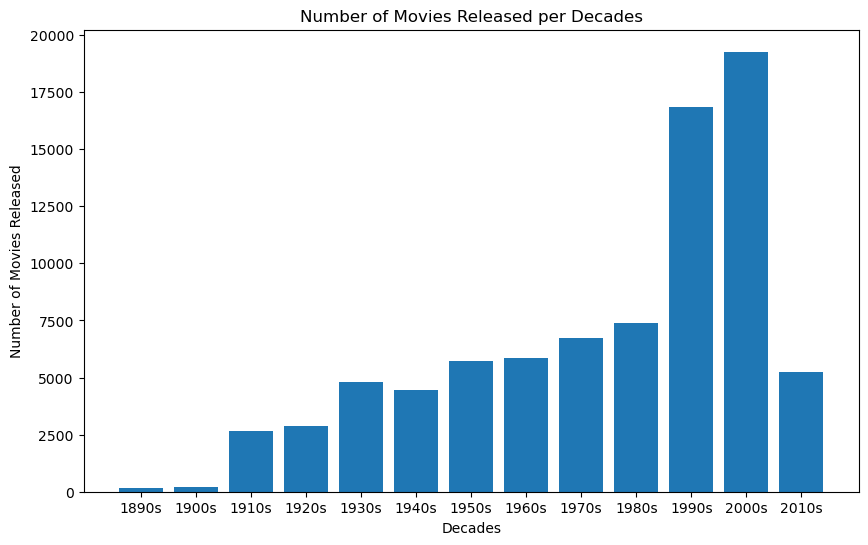

In [10]:
#We can plot the number of movies released per decades

movies_decades_data = {'Decades': ['1890s', '1900s', '1910s', '1920s', '1930s', '1940s', '1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s'],
                        'Number of Movies Released': [len(_1890s), len(_1900s), len(_1910s), len(_1920s), len(_1930s), len(_1940s), len(_1950s),
                                                     len(_1960s), len(_1970s), len(_1980s), len(_1990s), len(_2000s), len(_2010s)]}
perdecades_df = pd.DataFrame(movies_decades_data)

plt.figure(figsize=(10,6))
plt.bar(perdecades_df['Decades'], perdecades_df['Number of Movies Released'])
plt.xlabel('Decades')
plt.ylabel('Number of Movies Released')
plt.title('Number of Movies Released per Decades')
plt.show()

#### Plot Analysis
What do we do with the data in 1890s and 1900s? Should we omit them or combine them?
What about the 8.44% of missing data? Do we manually find the data or do we remove them from data frame?

In [11]:
#We now want to classify our movie data by genre.
test = movies_df.query('Genres == "Thriller"')
movies_df['Genres'][0]
#The movies all have many genres in their column, should we keep only the first one? or have movies that are in multiple genres?

'{"/m/01jfsb": "Thriller", "/m/06n90": "Science Fiction", "/m/03npn": "Horror", "/m/03k9fj": "Adventure", "/m/0fdjb": "Supernatural", "/m/02kdv5l": "Action", "/m/09zvmj": "Space western"}'

#### Project plotline
1) Finish movies_df exploratory data analysis by sorting the dataset by genres
2) Associate the characters to their respective movies and as such associate them to their movie's genres --> sorting the characters by genre
3) Sort the characters by decade and genre
4) Figure out the main characters from the side characters using freebase character map & plot summary --> Hardest part!

In [12]:
characters_df.head()

,Wiki_movieID,Freebase_movieID,ReleaseDate,CharacterName,ActorDOB,ActorGender,ActorHeight,ActorEthnicity,ActorName,ActorAge,Freebase_charactermap,Freebase_characterID,Freebase_actorID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [13]:
ethnicities = characters_df.ActorEthnicity.values

In [14]:
notmissing_ethnicities = characters_df['ActorEthnicity'].count()
totaldata_ethnicity = len(characters_df['ActorEthnicity'])
percentage_missing_ethnicity = (1 - (notmissing_ethnicities/totaldata_ethnicity)) * 100
print('The percentage of missing data in ActorEthnicity column is: %.2f%%' % percentage_missing_ethnicity)

The percentage of missing data in ActorEthnicity column is: 76.47%


In [15]:
notmissing_age = characters_df['ActorAge'].count()
totaldata_age = len(characters_df['ActorAge'])
percentage_missing_age = (1 - (notmissing_age/totaldata_age)) * 100
print('The percentage of missing data in ActorAge column is: %.2f%%' % percentage_missing_age)

The percentage of missing data in ActorAge column is: 35.08%


In [26]:
characters_df_with_movieinfo = characters_df.merge(movies_df, on=['Wiki_movieID'], how = 'left', suffixes=("", "_y")).drop(['Freebase_movieID_y', 'ReleaseDate_y'], axis=1)
characters_df_with_movieinfo.head()

,Wiki_movieID,Freebase_movieID,ReleaseDate,CharacterName,ActorDOB,ActorGender,ActorHeight,ActorEthnicity,ActorName,ActorAge,Freebase_charactermap,Freebase_characterID,Freebase_actorID,MovieName,BoxOffice,Runtime,Languages,Countries,Genres
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."


In [27]:
import json
df_tropes = pd.read_csv('data/tvtropes.clusters.txt', delimiter="\t", names=['trope', 'character'])
json_obj = df_tropes['character'].apply(json.loads)
df_tropes_norm = pd.json_normalize(json_obj[0])
for i in range(1, len(json_obj)):
    df_norm = pd.json_normalize(json_obj[i])
    df_tropes_norm = pd.concat([df_tropes_norm, df_norm], ignore_index=True)

df_tropes_final = pd.concat([df_tropes.drop('character', axis=1), df_tropes_norm], axis=1)

df_tropes_final = df_tropes_final.rename(columns={'id': 'Freebase_characterID', 'char':'CharacterName'})
df_tropes_final

,trope,CharacterName,movie,Freebase_characterID,actor
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader
...,...,...,...,...,...
496,young_gun,Morgan Earp,Tombstone,/m/0k776f,Bill Paxton
497,young_gun,Colorado Ryan,Rio Bravo,/m/0k2kqg,Ricky Nelson
498,young_gun,Tom Sawyer,The League of Extraordinary Gentlemen,/m/0k5nsh,Shane West
499,young_gun,William H. 'Billy the Kid' Bonney,Young Guns II,/m/03lrjk0,Emilio Estevez


In [23]:
#merge didn't work
characters_df_with_movieinfo_tropes = characters_df_with_movieinfo.merge(df_tropes_final, on=['Freebase_characterID'], how = 'left', suffixes=("", "_y"))
characters_df_with_movieinfo_tropes.head()

,Wiki_movieID,Freebase_movieID,ReleaseDate,CharacterName,ActorDOB,ActorGender,ActorHeight,ActorEthnicity,ActorName,ActorAge,...,MovieName,BoxOffice,Runtime,Languages,Countries,Genres,trope,CharacterName_y,movie,actor
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,...,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",NaN,NaN,NaN,NaN
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,...,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",NaN,NaN,NaN,NaN
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,...,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",NaN,NaN,NaN,NaN
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,...,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",NaN,NaN,NaN,NaN
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,...,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",NaN,NaN,NaN,NaN


In [24]:
notmissing_tropes = characters_df_with_movieinfo_tropes['trope'].count()
totaldata_tropes = len(characters_df_with_movieinfo_tropes['trope'])
percentage_missing_tropes = (1 - (notmissing_tropes/totaldata_tropes)) * 100
print('The percentage of missing data in Trope column is: %.2f%%' % percentage_missing_tropes)

The percentage of missing data in Trope column is: 100.00%
